In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

In [2]:
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.Analysis_functions as Analysis_functions
import src.SMT_Analysis_BP.helpers.MSD_Utils as MSD_Utils
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.optimize as opt

In [3]:
def track_gen_util(hurst,track_num,track_length,diffusion_coefficient):
    # Generate a track with given hurst parameter and track length for each track
    num_tracks = track_num
    track_length = track_length
    hurst = hurst
    track_dict = {}
    for i in range(num_tracks):
        track = fbm_utility.get_fbm_sample(1,hurst,2,track_length)
        _,track_2d = track
        #remap the 2d track from [[x1,x2,x3...],[y1,y2,y3...]] to [[x1,y1],[x2,y2],[x3,y3]...]
        track_2d = np.transpose(track_2d)*np.sqrt(2*diffusion_coefficient) + 100 #shift to avoid -ve values
        track_dict[i+1] = track_2d
    return track_dict

def combine_track_dict_util(*dicts):
    #assume agrs are dictionaries of the tracks
    track_dict_list = [i for i in dicts]
    combined_dict = {}
    track_counter = 1
    for track_dict in track_dict_list:
        for track in track_dict.values():
            combined_dict[track_counter] = track
            track_counter += 1
    return combined_dict

#utility function to plot histogram of the displacements
def plot_displacement_histogram(ens_displacements,fig,ax,bins=100):
        values, bin_edges = np.histogram(ens_displacements, bins=100, density=True)
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        ax.plot(bin_centers, values,marker='o',linestyle='None')
        return fig,ax

#utility function of gaussian fit
def gaussian(x, mu, sig,amp):
        return amp*(1./(sig*np.sqrt(2*np.pi)))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
#multi gaussian fit using gaussian function
def multi_gaussian(x, *params):
        y = np.zeros_like(x)
        for i in range(0, len(params), 3):
            mu, sig, amp = params[i:i+3]
            y = y + gaussian(x, mu, sig, amp)
        return y



        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ############################################################################

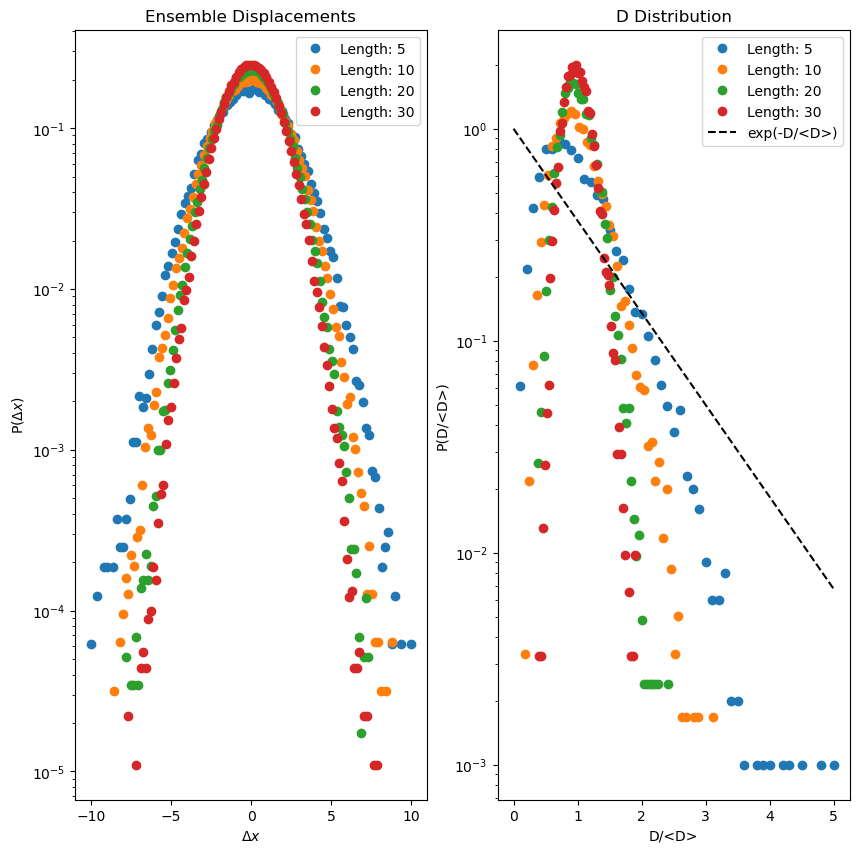

In [93]:
lengths = [5,10,20,30]
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_list = [ax1,ax2]
for ll in range(len(lengths)):
    a = track_gen_util(
        hurst=0.2,
        track_num=10000,
        track_length=lengths[ll],
        diffusion_coefficient=5
    )
    # b = track_gen_util(
    #     hurst=0.2,
    #     track_num=5000,
    #     track_length=lengths[ll],
    #     diffusion_coefficient=20
    # )

    combined_a_b = a#combine_track_dict_util(a,b)
    #print(combined_a_b)
    msd_c = MSD_Utils.MSD_Calculations_Track_Dict(combined_a_b,pixel_to_um=1,frame_to_seconds=1)

    ens_displacements = np.array(msd_c.individual_store.ensemble_displacement[1]).flatten()

    #fit the displacements to a gaussian
    mu, std = norm.fit(ens_displacements)


    #plot the displacement distribution and the fitted gaussian
    # rather than bar histogram, use a line histogram with points at the bin centers

    values_2, bin_edges = np.histogram(ens_displacements, bins=100, density=True)
    bin_centers_2 = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax1.plot(bin_centers_2, values_2,marker='o',linestyle='None',label='Length: {0}'.format(lengths[ll]))

    #lets look at the individual track_MSD 
    tracks = msd_c.individual_store.track_MSD

    #for each track fit the msd to find the D estimate
    D_estimate_2 = []
    for i,j in tracks.items():
        msds = np.array(list(j.values()))
        tau = np.array(list(j.keys()))
        D_estimate_2.append(msds[0]/tau[0]/4.)
    #plot the histogram of the D_estimate/<D>
    D_ratio_D_avg = np.array(D_estimate_2)/np.mean(D_estimate_2)
    ratio_val,bin_edges = np.histogram(D_ratio_D_avg,bins=50,density=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax2.plot(bin_centers,ratio_val,marker='o',linestyle='None',label='Length: {0}'.format(lengths[ll]))
    if ll == len(lengths)-1:
        #plot an exponential line to show the expected distribution
        ax2.plot(np.linspace(0,5,100),np.exp(-np.linspace(0,5,100)),label="exp(-D/<D>)",linestyle="--",color = "black")
    # if ll == len(lengths)-1:
    #     #fit the values to a single gaussian
    #     p0 = [0.5,0.5,0.5,0.5,0.5,0.5]
    #     popt, pcov = opt.curve_fit(multi_gaussian, bin_centers_2, values_2, p0=p0)
    #     print(popt)
    #     ax1.plot(bin_centers_2, multi_gaussian(bin_centers_2, *popt), 'k--')
        
ax2.set_yscale("log")
    
ax1.legend()
ax2.legend()
ax1.set_title("Ensemble Displacements")
ax1.set_xlabel("$\Delta x$")
ax1.set_ylabel("P($\Delta x$)")
ax1.set_yscale('log')
ax2.set_title("D Distribution")
ax2.set_xlabel("D/<D>")
ax2.set_ylabel("P(D/<D>)")
#save the figure
plt.savefig("Gaussian_step_size_FBM_one_diff.png",dpi=300)
plt.show()



        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ############################################################################

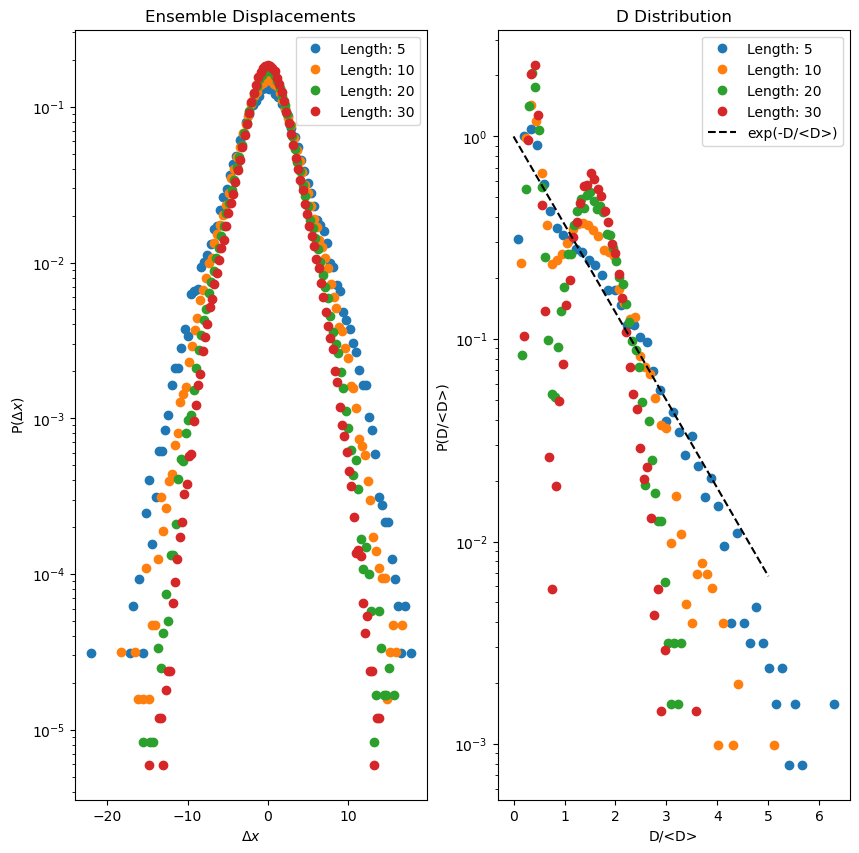

In [94]:
lengths = [5,10,20,30]
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_list = [ax1,ax2]
for ll in range(len(lengths)):
    a = track_gen_util(
        hurst=0.2,
        track_num=5000,
        track_length=lengths[ll],
        diffusion_coefficient=5
    )
    b = track_gen_util(
        hurst=0.2,
        track_num=5000,
        track_length=lengths[ll],
        diffusion_coefficient=20
    )

    combined_a_b = combine_track_dict_util(a,b)
    #print(combined_a_b)
    msd_c = MSD_Utils.MSD_Calculations_Track_Dict(combined_a_b,pixel_to_um=1,frame_to_seconds=1)

    ens_displacements = np.array(msd_c.individual_store.ensemble_displacement[1]).flatten()

    #fit the displacements to a gaussian
    mu, std = norm.fit(ens_displacements)


    #plot the displacement distribution and the fitted gaussian
    # rather than bar histogram, use a line histogram with points at the bin centers

    values_2, bin_edges = np.histogram(ens_displacements, bins=100, density=True)
    bin_centers_2 = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax1.plot(bin_centers_2, values_2,marker='o',linestyle='None',label='Length: {0}'.format(lengths[ll]))

    #lets look at the individual track_MSD 
    tracks = msd_c.individual_store.track_MSD

    #for each track fit the msd to find the D estimate
    D_estimate_2 = []
    for i,j in tracks.items():
        msds = np.array(list(j.values()))
        tau = np.array(list(j.keys()))
        D_estimate_2.append(msds[0]/tau[0]/4.)
    #plot the histogram of the D_estimate/<D>
    D_ratio_D_avg = np.array(D_estimate_2)/np.mean(D_estimate_2)
    ratio_val,bin_edges = np.histogram(D_ratio_D_avg,bins=50,density=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax2.plot(bin_centers,ratio_val,marker='o',linestyle='None',label='Length: {0}'.format(lengths[ll]))
    if ll == len(lengths)-1:
        #plot an exponential line to show the expected distribution
        ax2.plot(np.linspace(0,5,100),np.exp(-np.linspace(0,5,100)),label="exp(-D/<D>)",linestyle="--",color = "black")
    # if ll == len(lengths)-1:
    #     #fit the values to a single gaussian
    #     p0 = [0.5,0.5,0.5,0.5,0.5,0.5]
    #     popt, pcov = opt.curve_fit(multi_gaussian, bin_centers_2, values_2, p0=p0)
    #     print(popt)
    #     ax1.plot(bin_centers_2, multi_gaussian(bin_centers_2, *popt), 'k--')
        
ax2.set_yscale("log")
    
ax1.legend()
ax2.legend()
ax1.set_title("Ensemble Displacements")
ax1.set_xlabel("$\Delta x$")
ax1.set_ylabel("P($\Delta x$)")
ax1.set_yscale('log')
ax2.set_title("D Distribution")
ax2.set_xlabel("D/<D>")
ax2.set_ylabel("P(D/<D>)")
#save the figure
plt.savefig("Gaussian_step_size_FBM_two_diff_ratio_5.png",dpi=300)
plt.show()



        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ##############################################################################################################
        #You have initialized a Calculation class with the following parameters:
        #pixel_size: 1
        #frame_length: 1
        #pixel_unit: um
        #frame_unit: s
        

        ############################################################################

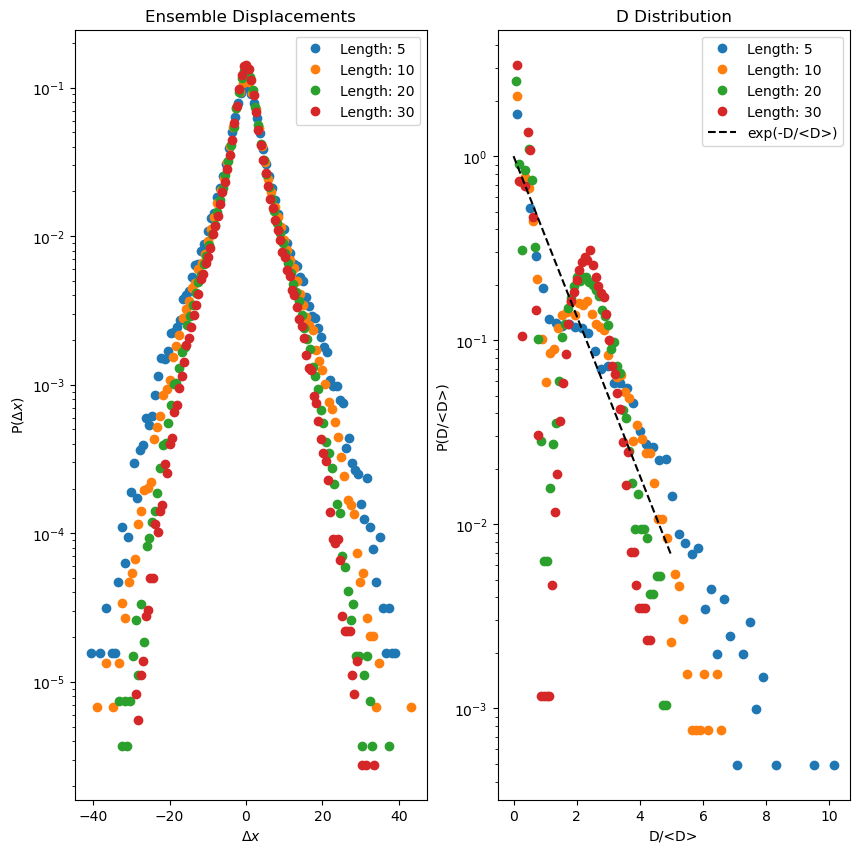

In [7]:
lengths = [5,10,20,30]
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax_list = [ax1,ax2]
for ll in range(len(lengths)):
    a = track_gen_util(
        hurst=0.2,
        track_num=3300,
        track_length=lengths[ll],
        diffusion_coefficient=5
    )
    b = track_gen_util(
        hurst=0.2,
        track_num=3300,
        track_length=lengths[ll],
        diffusion_coefficient=20
    )
    c = track_gen_util(
        hurst=0.2,
        track_num=3300,
        track_length=lengths[ll],
        diffusion_coefficient=100
    )
    combined_a_b = combine_track_dict_util(a,b,c)
    #print(combined_a_b)
    msd_c = MSD_Utils.MSD_Calculations_Track_Dict(combined_a_b,pixel_to_um=1,frame_to_seconds=1)

    ens_displacements = np.array(msd_c.individual_store.ensemble_displacement[1]).flatten()

    #fit the displacements to a gaussian
    mu, std = norm.fit(ens_displacements)


    #plot the displacement distribution and the fitted gaussian
    # rather than bar histogram, use a line histogram with points at the bin centers

    values_2, bin_edges = np.histogram(ens_displacements, bins=100, density=True)
    bin_centers_2 = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax1.plot(bin_centers_2, values_2,marker='o',linestyle='None',label='Length: {0}'.format(lengths[ll]))

    #lets look at the individual track_MSD 
    tracks = msd_c.individual_store.track_MSD

    #for each track fit the msd to find the D estimate
    D_estimate_2 = []
    for i,j in tracks.items():
        msds = np.array(list(j.values()))
        tau = np.array(list(j.keys()))
        D_estimate_2.append(msds[0]/tau[0]/4.)
    #plot the histogram of the D_estimate/<D>
    D_ratio_D_avg = np.array(D_estimate_2)/np.mean(D_estimate_2)
    ratio_val,bin_edges = np.histogram(D_ratio_D_avg,bins=50,density=True)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax2.plot(bin_centers,ratio_val,marker='o',linestyle='None',label='Length: {0}'.format(lengths[ll]))
    if ll == len(lengths)-1:
        #plot an exponential line to show the expected distribution
        ax2.plot(np.linspace(0,5,100),np.exp(-np.linspace(0,5,100)),label="exp(-D/<D>)",linestyle="--",color = "black")
    # if ll == len(lengths)-1:
    #     #fit the values to a single gaussian
    #     p0 = [0.5,0.5,0.5,0.5,0.5,0.5]
    #     popt, pcov = opt.curve_fit(multi_gaussian, bin_centers_2, values_2, p0=p0)
    #     print(popt)
    #     ax1.plot(bin_centers_2, multi_gaussian(bin_centers_2, *popt), 'k--')
        
ax2.set_yscale("log")
    
ax1.legend()
ax2.legend()
ax1.set_title("Ensemble Displacements")
ax1.set_xlabel("$\Delta x$")
ax1.set_ylabel("P($\Delta x$)")
ax1.set_yscale('log')
ax2.set_title("D Distribution")
ax2.set_xlabel("D/<D>")
ax2.set_ylabel("P(D/<D>)")
#save the figure
plt.savefig("Gaussian_step_size_FBM_three_diff_ratio_4_20.png",dpi=300)
plt.show()


[9.51044573e-12 5.63764604e-01 9.99793015e-01]


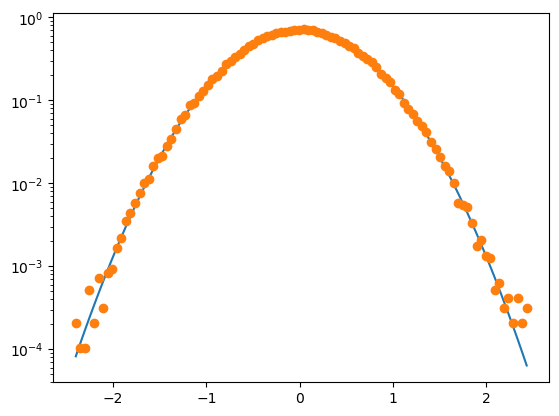

[2.08217946e-10 5.63765178e-01 4.86503044e-01 1.86416984e-18
 5.63764061e-01 5.13289972e-01]


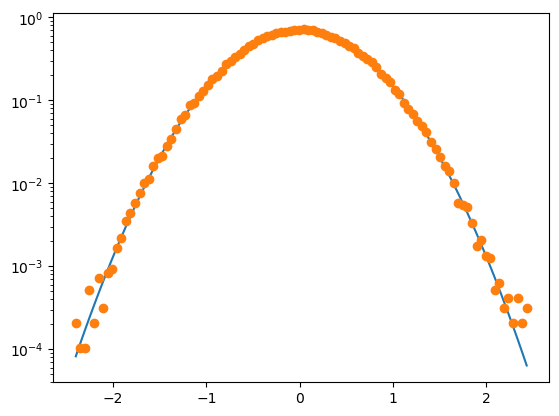

In [48]:
#lets use curvefit to fit the gaussian function to the ensemble displacements
#first we need to get the bin centers and the values of the histogram
values, bin_edges = np.histogram(ens_displacements, bins=100, density=True)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

#now we can use curvefit to fit the gaussian function to the histogram
#we need to provide an initial guess for the parameters
initial_guess = [0,0.1,1]
#use the constraint
popt, pcov = opt.curve_fit(gaussian, bin_centers, values, p0=initial_guess,bounds=([0,0,0],[np.inf,np.inf,np.inf]),method='trf')
print(popt)
#plot the fitted gaussian
plt.plot(bin_centers,gaussian(bin_centers,*popt))
plt.plot(bin_centers,values,marker='o',linestyle='None')
plt.yscale("log")
plt.show()

#repeat the same for a multi gaussian fit
#first we need to get the bin centers and the values of the histogram
values, bin_edges = np.histogram(ens_displacements, bins=100, density=True)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

#now we can use curvefit to fit the gaussian function to the histogram
#we need to provide an initial guess for the parameters
initial_guess = [0,0.1,1,0,0.1,0]
#use the constraint
popt, pcov = opt.curve_fit(multi_gaussian, bin_centers, values, p0=initial_guess,bounds=([0,0,0,0,0,0],[np.inf,np.inf,1,np.inf,np.inf,1]),method='trf')
print(popt)
#plot the fitted gaussian
plt.plot(bin_centers,multi_gaussian(bin_centers,*popt))
plt.plot(bin_centers,values,marker='o',linestyle='None')
plt.yscale("log")
plt.show()




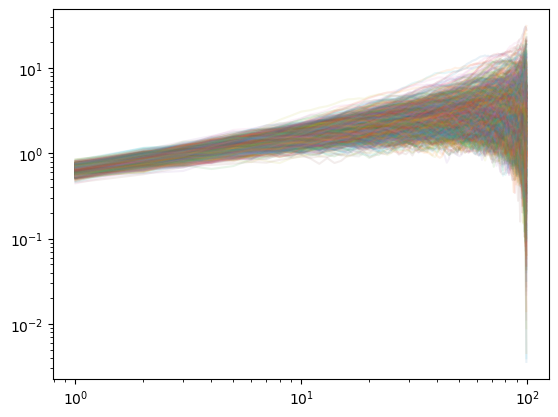

In [49]:
#lets look at the individual track_MSD 
tracks = msd_c.individual_store.track_MSD
for i,j in tracks.items():
    msds = np.array(list(j.values()))
    tau = np.array(list(j.keys()))
    plt.plot(tau,msds,alpha=0.1)
plt.yscale("log")
plt.xscale("log")
plt.show()

#for each track fit the msd to the power law in MSD_Utils
D_estimate = []
A_estimate = []
D_estimate_2 = []
for i,j in tracks.items():
    msds = np.array(list(j.values()))
    tau = np.array(list(j.keys()))
    D_estimate_2.append(msds[0]/tau[0]/4.)




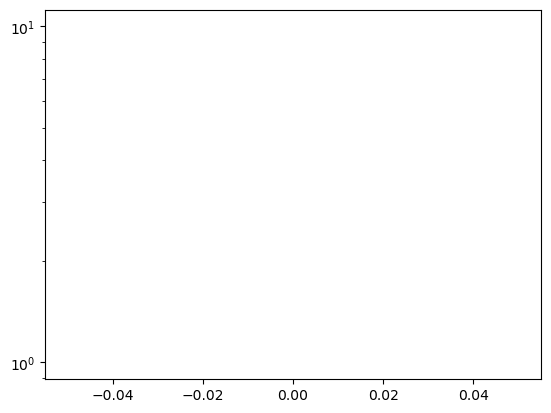

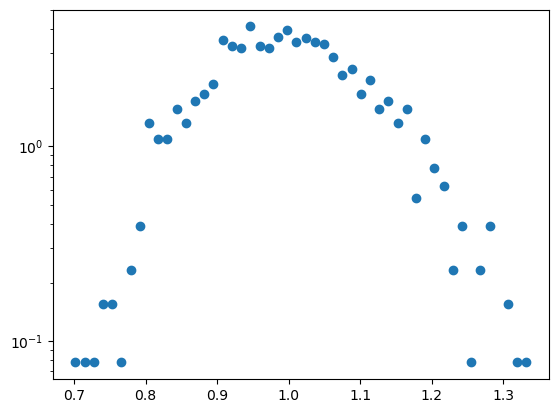

In [51]:
#plot the histogram of the D_estimate/<D>
D_ratio_D_avg = np.array(D_estimate_2)/np.mean(D_estimate_2)
ratio_val,bin_edges = np.histogram(D_ratio_D_avg,bins=50,density=True)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
plt.plot(bin_centers,ratio_val,marker='o',linestyle='None')
plt.yscale("log")
plt.show()